In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import tensorflow as tf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
url2 = 'C:\\Users\\86152\\Desktop\\BCHAIN-MKPRU.csv'
df_bit = pd.read_csv(url2)
df_bit["Date"] = pd.to_datetime(df_bit["Date"], errors="coerce", format="%m/%d/%y")

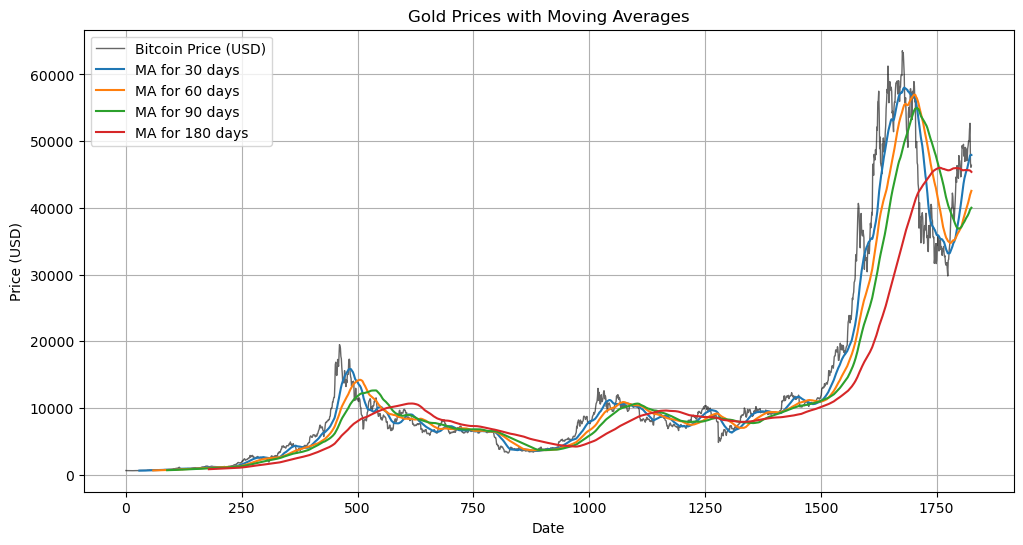

In [ ]:
#Moving Average
ma_day = [30, 60, 90, 180]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_bit[column_name] = df_bit['Value'].rolling(ma).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_bit['Value'], label='Bitcoin Price (USD)', linewidth=1, color='black', alpha=0.6)
for ma in ma_day:
    plt.plot(df_bit[f"MA for {ma} days"], label=f'MA for {ma} days')

# Add title, labels, and legend
plt.title('Gold Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Normalization
price = df_bit['Value'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [ ]:
current_date = datetime.strptime('2021-08-10', '%Y-%m-%d')
predicted = {}
true = {}
abs = 0
for j in range(32):
    X, y = [], []
    for i in range(1500, len(price_scaled) - 32 + j):#Here start ponit is 1500. Adjust 1500 if use other start ponit
        X.append(price_scaled[i-1:i, 0])#Here timestep is 1. Adjust 1 other timesteps
        y.append(price_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    # Reshape X to the shape LSTM needs (samples, time steps, features)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    # Build LSTM Model
    model = Sequential()
    model.add(Input(shape=(X.shape[1], 1))) 
    model.add(LSTM(units=64, return_sequences=True))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(LSTM(units=32))
    model.add(Dense(units=1))
    # Compile Model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train Model
    model.fit(X, y, epochs=100, batch_size=32)#Change trainning epochs
    start_idx = -(32 - j + 1)#Here timestep is 1. Adjust 1 other timesteps
    end_idx = -(32 - j)
    input_data = price_scaled[start_idx:end_idx].reshape(1, 1, 1)#Here timestep is 1. Adjust the middle 1 other timesteps
    predicted_price = model.predict(input_data)
    true_price_new = price_scaled[-32 + j]
    abs += np.abs(predicted_price - true_price_new)
    # Anti-normalization
    future_price = []
    future_price.append(predicted_price[0, 0])
    future_price = scaler.inverse_transform(np.array(future_price).reshape(-1, 1))
    predicted[current_date] = future_price
    true_price = df_bit['Value'].values[-32 + j]
    true[current_date] = true_price
    print(current_date, true_price, future_price)
    current_date += timedelta(days=1)

print(f"Absolute Error: {abs}")
print(predicted)
            
        

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3972
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3546 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2890 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1577 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0443 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0265 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133 
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101 
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

In [18]:
predicted_df = pd.DataFrame(
    [(date, value[0][0]) for date, value in predicted.items()],
    columns=['Date', 'Predicted Value']
)
print(predicted_df)

         Date  Predicted Value
0  2021-08-10     43273.160156
1  2021-08-11     46232.277344
2  2021-08-12     44429.230469
3  2021-08-13     45173.132812
4  2021-08-14     43959.199219
5  2021-08-15     48126.882812
6  2021-08-16     46614.292969
7  2021-08-17     46886.152344
8  2021-08-18     45591.804688
9  2021-08-19     44686.207031
10 2021-08-20     44207.187500
11 2021-08-21     46808.164062
12 2021-08-22     48668.949219
13 2021-08-23     48235.636719
14 2021-08-24     49294.820312
15 2021-08-25     49148.304688
16 2021-08-26     47288.042969
17 2021-08-27     48959.203125
18 2021-08-28     47065.921875
19 2021-08-29     48986.496094
20 2021-08-30     48805.628906
21 2021-08-31     48752.476562
22 2021-09-01     46744.578125
23 2021-09-02     47319.886719
24 2021-09-03     48647.273438
25 2021-09-04     50062.816406
26 2021-09-05     50038.980469
27 2021-09-06     50413.339844
28 2021-09-07     51477.816406
29 2021-09-08     52579.855469
30 2021-09-09     46222.578125
31 2021-

In [19]:
import os

# Define the desktop path
desktop_path = os.path.expanduser("~/Desktop/")

# Save the DataFrame to CSV
csv_filename = os.path.join(desktop_path, "df_bit_predicted2.csv")
predicted_df.to_csv(csv_filename, index=False)

print(f"DataFrame saved to {csv_filename}")

DataFrame saved to C:\Users\86152/Desktop/df_bit_predicted2.csv
